# <strong> The Goal </strong>
Provide a specific set of recommendations on how to improve The Client's business based on the provided data. Provide the recommendations and any supporting analyses and assumptions.
# <strong> Approach </strong>
## 1. QA Data 
- confirm all data is present and entered correctly. If null values are present, determine whether to 
    1) drop row values
    2) impute null values using other row indicators, if applicable
    
## 2. Exploratory Data Analysis
- look for trends in the data and see if any obvious patterns emerge. Make sure data trends make sense - if they do not, reevaluate data quality and determine reason for discrepancy
- look for patterns that emerge (or don't)
- identify target metrics for improvement
    
## 3. (Time Permitting) Competitive Analysis / ML Analysis 
- compare The Client data to competitors (e.g. DoorDash, UberEats, GrubHub, and proprietary food delivery services like Domino's) and identify gaps / competitive advantages
- using the sklearn library, utilize the appropriate models to look for most impactful indicators to either further exploit advantages or close gaps


# PHASE 1: Import & QA the dataset

## 1a) Import the dataset and instantiate the dataframe

In [1]:
#import the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
#the dts list denotes the columns that represent datetimes. Because the datetime format provided is not standard, 
#we will not adjust them when we instatiate the dataframe; we will adjust each column with pd.to_datetime. 
dts = ["Customer placed order datetime", 
       "Placed order with restaurant datetime", 
       "Driver at restaurant datetime", 
       "Delivered to consumer datetime"]
#instatiate the dataframe from the provided excel
df = pd.read_excel("Sample deliveries data - 1 month (1) (2).xlsx")
#Convert datetime columns to appropriate data types, and convert from base UTC to the Client's operational time zone (PT)  
for col in dts:
    df[col] = pd.to_datetime(df[col], format = "%d %H:%M:%S", utc=True).dt.tz_convert('US/Pacific')

## 1b) check for missing values in dataframe 

In [2]:
print(f'Unique delivery regions: {df["Delivery Region"].unique()}')
print(f'{len(df[df["Delivery Region"]=="None"])} entries do not have region data')
df["Delivery Region"].replace({"None": np.nan}, inplace=True)
print("\n# Missing values for each column:")
df.isna().sum()

Unique delivery regions: ['Mountain View' 'Palo Alto' 'San Jose' 'None']
26 entries do not have region data

# Missing values for each column:


Customer placed order datetime              0
Placed order with restaurant datetime      40
Driver at restaurant datetime            4531
Delivered to consumer datetime              0
Driver ID                                   0
Restaurant ID                               0
Consumer ID                                 0
Delivery Region                            26
Is ASAP                                     0
Order total                                 0
Amount of discount                          0
Amount of tip                               0
Refunded amount                             0
dtype: int64

#### Problems: 
- 3 columns ("Placed order with restaurant datetime," "Delivery Region," and "Driver at restaurant datetime") are missing some data. This may impact analysis.

#### Mitigation Options: Two solutions present themselves for the datetime data: 
1. Impute the data where appropriate using the average delivery time.
    Deliver time can be inferred by comparing existing "driver at restaurant" and "delivered to consumer" times. This solution raises the below concerns.
        a) We do not have geolocation data; some customers may be placing orders at restaurants far away. 
        b) We do not know what method the driver is using the deliver the food (e.g. bike, motorcycle, car)
        c) We do not know the whether conditions on the given day, or other one-off events that cause atypical fluctuations in delivery times. 
2. Remove the columns. 
    When data quality is in question, it is oftentimes advisable to remove the questionable entries when it will not cause a material change to the dataset. In this case, 4500 rows represents almost 25% of all rows - removing this much data would cause a material change to data interpretation. 
        

#### Solutions
Per the above, I consider the uncertainty inherent in imputing values less of a concern than removing up 25% of data. 
1. For missing delivery region, I will impute using the most common delivery region (mode)
2. For missing driver at restaurant values, I will infer the missing data using the average (median) delivery time. The median is resistent to outliers. As we are missing significant context when it comes to deliveries (restaurant delays, distance, etc), the mode is a safer reflection of the average delivery time than the mean.
3. For order placed w/restaurant values, I will use a two pronged approach based on ASAP status:
    1. If the "IS ASAP" flag is True: 
        a) If the number missing data is material: I will impute order using the "order placed w/customer" value
        b) If the number missing data is not material: I will drop the rows from the relevant analysis
    2. If the order is not ASAP: order-time would be delayed from order placed. As we do not know the time the customer has specified for delivery given current data, we will leave these blank and not analyze non-asap orders


#### Assumptions
##### 1. Customers' distance from restaurants are all similar
##### 2. All drivers are using the same method of transportation (given the "Driver" denotation, likely a car)
##### 3. Weather conditions are immaterial to delivery time. As the delivery regions specified typically have driving-favorable weather, this is a very reasonable assumption
##### 4. We will not analyze non-asap orders per Solution 3.2 above

Note: For a more detailed analysis, we could additionally factor in delivery region and time-of-day to impute average delivery time. As I am limited on time, I will go with the simple region approach denoted in 

In [3]:
# Impute Delivery Region
df["Delivery Region"].fillna(df["Delivery Region"].mode()[0], inplace=True)
# Impute Driver at Restaurant
#      Step 1: Create delivery Driver_time_elapsed column
df["Driver_time_elapsed"] = df["Delivered to consumer datetime"] - df["Driver at restaurant datetime"]
#      Step 2: Create an integer column for feature engineering
df["Driver at restaurant datetime"] = df["Delivered to consumer datetime"] - df["Driver_time_elapsed"].median()
# Impute order placed w/restaurants for ASAP deliveries
print(f'ASAP status of orders missing order placement data: \n{df[df["Placed order with restaurant datetime"].isnull()]["Is ASAP"].value_counts()}')

ASAP status of orders missing order placement data: 
False    38
True      2
Name: Is ASAP, dtype: int64


Only two values missing order placement time are ASAP orders; this number is immaterial to any analysis. I will drop them. Let's confirm all the null values are gone now. 

In [4]:
df.isna().sum()

Customer placed order datetime              0
Placed order with restaurant datetime      40
Driver at restaurant datetime               0
Delivered to consumer datetime              0
Driver ID                                   0
Restaurant ID                               0
Consumer ID                                 0
Delivery Region                             0
Is ASAP                                     0
Order total                                 0
Amount of discount                          0
Amount of tip                               0
Refunded amount                             0
Driver_time_elapsed                      4531
dtype: int64

Great! All the null values are gone. I'll do a quick sanity check on the dataframe and make sure all the info still looks right after our transformations

In [5]:
# Make sure all the data looks correct. 
# QAing with the provided excel shows that the datetime conversion is a difference of 8 hours.
# This which is correct if Daylight savings time is not active. 
df.head(2)

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,Driver_time_elapsed
0,1899-12-31 18:59:12-07:53,1899-12-31 19:07:25-07:53,1899-12-31 19:19:58-07:53,1899-12-31 19:42:20-07:53,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0,00:27:11
1,1900-01-13 08:05:57-07:53,1900-01-13 10:03:45-07:53,1900-01-13 10:41:39-07:53,1900-01-13 11:04:01-07:53,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0,00:32:22


Everything's looking good. A quick sanity check on the timezones shows that the UTC to PT conversion clocks in at -8 hours, which fits if daylight savings time is not active (Pacific time is currently PST). 

#### Assumption: Pacific time is currently on PST (not PDT)

# Exploration 1: Demand trends
1. Can we get a better idea of what month this data is representing? 
2. Does food-delivery demand have any common trends?

### Step 1: Restrict analysis to operational month (PST, not UTC)

In [6]:
def order_check(num, df):
    return(f"Total # of orders check: {num}/{len(df)}")

Since orders can be placed in advance, monthly operational data can be best inferred by the date an order is delivered to a consumer

In [7]:
#Dataframe contains month values given in UTC; some values 
#(e.g. 1st day of the month, 2AM UTC) would actually belong to the previous operational month in Pacific Time 
pst_df = df[df["Delivered to consumer datetime"].dt.year != 1899]
print (f'The largest day # in the dataset in PT is: {pst_df["Delivered to consumer datetime"].dt.day.max()}')
print (f"of the {len(df)} entries provided, {len(pst_df)} are in the operational month")

The largest day # in the dataset in PT is: 30
of the 18078 entries provided, 17698 are in the operational month


### Step 2: Visualize data

Total # of orders check: 17698/17698


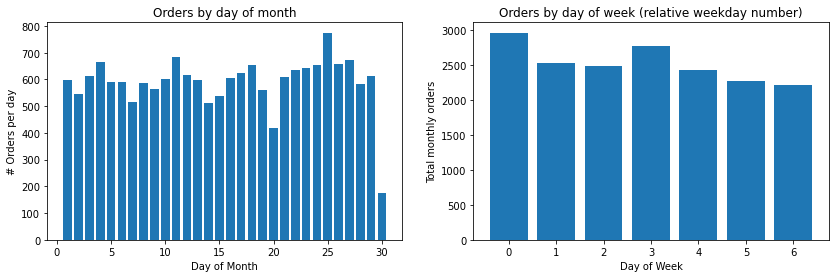

In [8]:
#Create pivot table with count of data entries per day ID
day_quant_table = pst_df.pivot_table(index = pst_df["Delivered to consumer datetime"].dt.day, aggfunc = "count")
weekday_quant_table = pst_df.pivot_table(index = pst_df["Delivered to consumer datetime"].dt.weekday, aggfunc = "count")

#Confirm that sum of orders equals the total number of orders in the dataframe (18078)
print(order_check(day_quant_table["Restaurant ID"].sum(), pst_df))
#Graph by day
fig, axes = plt.subplots(1,2, figsize=(14,4))
for table, ax in zip([day_quant_table, weekday_quant_table], axes):
    ax.bar(table.index, table["Restaurant ID"])
axes[0].set(title="Orders by day of month", xlabel="Day of Month", ylabel="# Orders per day");
axes[1].set(title="Orders by day of week (relative weekday number)", xlabel="Day of Week", ylabel="Total monthly orders");

Note: Day 30 in this example may be underrepresented by design, as our extract is pulled on UTC data. Thus, in the same way that this month's extract included some of last month's data, at least someof the Day 30 operational data for this month would be included in the next month's data, as UTC is ahead of PST. 

# Takeaways / Trends
Using the knowledge that the largest day contained in the date columns is 30, we know that we are operating in a month with 31 days. Thus, we know this data comes from either September, April, June, and November. 

The data also seems to follow two patterns a 7-day basis:
    1. Starting with Day #4, every 7th day appears to see a relative spike in orders
    2. Starting with Day #7, every 7th day represents a relative trough in order demand
    

# Demand trends require further exploration
We have a clear relative trend of order volume by relative weekday, but what month and year is this data exerpt taken from? Knowing the time will provide clarity as to which weekdays are most valuable. 
- We know that this data comes from either Sept, April, June, or November
    
- The data is exposing a clear demand trend that seems to hold for almost the entire duration of the data provided. Knowing which month would allow us to determine which weekdays the Client sees peak demand and likewise, which weekdays demand suffers. Knowing what month this data is from would also allow us to cross-reference our demand data with likely confounding variables, such as holidays. For example, the massive decline in demand seen in Days 20 and 30 could be explained by national holidays  

# Exploration 2: Delivery Trends
1. Are there any significant lead times when communicicating Client orders to partner restaurants?
    - Are certain restaurants suffering from disproportionately long lead-times? 
2. Do monetary KPIs differ by delivery region?
    - Create the same time-series as #2, grouped by Delivery Region
3. Do certain consumers out-refund others? Why?
    - Group monetary kpis by consumer ID and look for outliers 
4. (Time-permitting) Do certain drivers outperform others?
    - Group monetary kpis by driver ID and look for outliers
5. (Time-permitting) Do certain restaurants stand out (for better or for worse?)
    - Group monetary KPIs by restaurant.
        - Do discounts correspond to increased order volume?
        - Do some restaurants account for a larger share of order totals?
        - Are some restaurants more likely to be associated with refunded orders?


## 1. Restaurant Order lead-times

In [9]:
pst_df["order_lt"] = pst_df["Placed order with restaurant datetime"] - pst_df["Customer placed order datetime"]
pst_df["order_lt_min"] = pst_df["order_lt"].dt.seconds/60
#order lead times are only relevant for orders placed for immediate delivery; 
# the current dataset does not have data to analyze orders placed for delayed delivery
pst_df[pst_df["Is ASAP"]]["order_lt"].describe()

count                     14104
mean     0 days 00:04:28.898468
std      0 days 06:03:04.639094
min          -30 days +04:56:24
25%             0 days 00:01:17
50%             0 days 00:03:14
75%             0 days 00:09:09
max             2 days 19:59:58
Name: order_lt, dtype: object

Looks like there may be some data integrity issues - some orders seem to have placed an order with the restaurant significantly before the customer even placed the order. I'll drop all the values that have orders placed with restaurants before the customer places their order.

In [10]:
time_df = pst_df.drop(pst_df[pst_df["Placed order with restaurant datetime"] < pst_df["Customer placed order datetime"]].index)
time_df[time_df["Is ASAP"]]["order_lt"].describe()

count                     14103
mean     0 days 00:07:31.447209
std      0 days 00:35:37.410277
min             0 days 00:00:06
25%             0 days 00:01:17
50%             0 days 00:03:14
75%             0 days 00:09:09
max             2 days 19:59:58
Name: order_lt, dtype: object

That looks better! Immediate takeaways are that some orders are placed almost immediately (6 seconds!), though over 75% of all orders take over a minute to place with the restaurant. If we can partner more closely with our partner restaurants and integrate their order queue directly to the Client's App, we can reduce order delays to almost 0! 

Let's see if there are any other specific insights we can glean

# orders placed in each region:
Palo Alto        11218
Mountain View     3668
San Jose          2801
Name: Delivery Region, dtype: int64


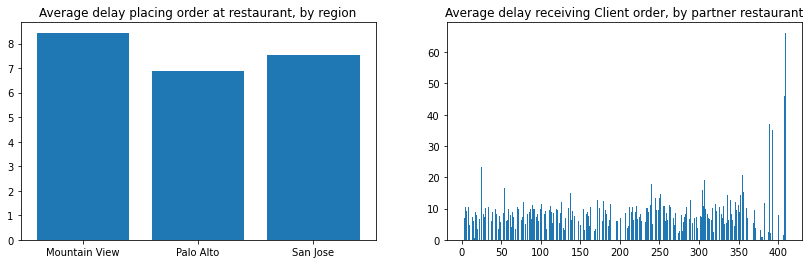

In [11]:
fig, axes = plt.subplots(1,2, figsize = (14,4))

chart_regions = time_df[time_df["Is ASAP"]].groupby("Delivery Region").mean()["order_lt_min"]
chart_restaurants = time_df[time_df["Is ASAP"]].groupby("Restaurant ID").mean()["order_lt_min"]
titles = ["Average delay placing order at restaurant, by region", "Average delay receiving Client order, by partner restaurant"]
print(f"# orders placed in each region:\n{time_df['Delivery Region'].value_counts()}")

for chart, ax, title in zip([chart_regions, chart_restaurants], axes, titles):
    ax.bar(chart.index, chart)
    ax.set_title(title)

Regions: Palo Alto seem to have the lowest average delivery time, but it's still over 6 minutes. As the Client already has significant market penetration in Palo Alto, it should prioritize developing relationships in Mountain View and San Jose to continue to improve customer and partner experience and further penetrate these markets

Restaurants: Most restaurants have around a 10 minute delay, but a handful have scary high delays in receiving Client orders. Let's identify what restaurants those are, and work with them to fix whatever issue is causing these massive delays

In [12]:
print (f"There are {len(chart_restaurants[chart_restaurants > 10])} restaurants with average order lead times > 10 min.")
print(f"They received a total of {pst_df['Restaurant ID'].isin(chart_restaurants[chart_restaurants > 10].index).sum()} orders")

#Identify high-lead time restaurants with the highest volume of orders       
big_delays = pst_df[pst_df["Restaurant ID"].isin(chart_restaurants[chart_restaurants > 10].index)].\
pivot_table(index="Restaurant ID", values = "Consumer ID", aggfunc="count").\
sort_values("Consumer ID", ascending=False).rename({"Consumer ID": "# orders received"},axis=1).head(10)
      
print(f"\nThese 10 retaurants account for {big_delays['# orders received'].sum()} of the 2866 orders above:")
display(big_delays)

There are 78 restaurants with average order lead times > 10 min.
They received a total of 2866 orders

These 10 retaurants account for 1701 of the 2866 orders above:


,# orders received
Restaurant ID,
9,710
5,187
194,184
30,156
221,96
90,89
224,75
264,71
239,68


## Action Item: 
Work with the above 10 restaurants and determine ways to best reduce delays from the time a customer places an order with  the Client to the time the partner restaurant receives it. I hypothesize the best way to do this is to integrate the partner restaurant's order queue with the Client's order API, as this would cause orders to be placed with the partner restaurant instantaneously. However, more research is required. 

## 2. Monetary KPIs - by Delivery Region

In [13]:
# Review how many orders were placed in each region
pst_df["Delivery Region"].value_counts()

Palo Alto        11226
Mountain View     3670
San Jose          2802
Name: Delivery Region, dtype: int64

In [14]:
pst_df["tip % of order"] = pst_df["Amount of tip"] / pst_df["Order total"] * 100
money_kpis = ["Order total", "tip % of order", "Refunded amount", "Amount of discount"]

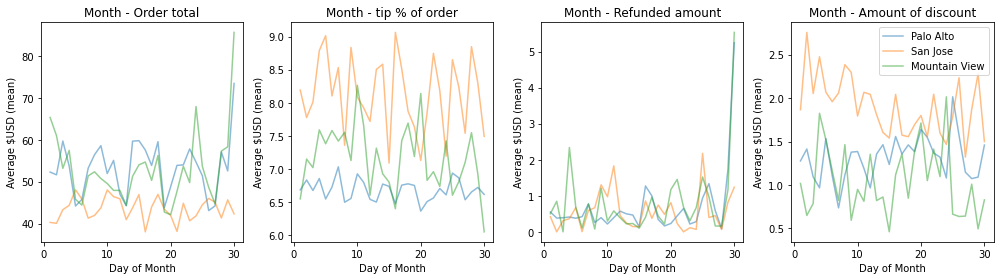

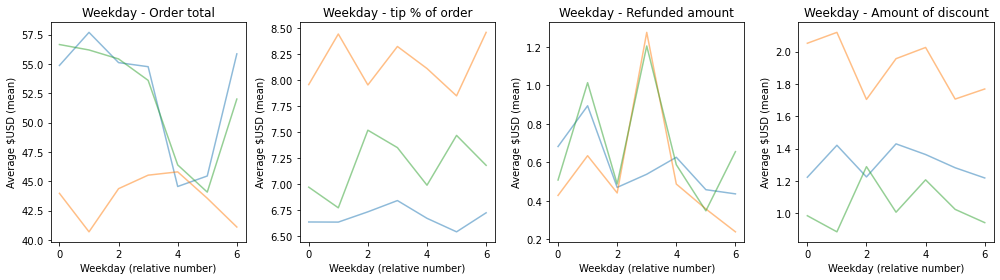

In [15]:
fig, axes = plt.subplots(1,4, figsize=(14,4))
legend_order = []
for region in pst_df["Delivery Region"].unique():
    for kpi, ax in zip(money_kpis, axes):
        temp = pst_df[pst_df["Delivery Region"]==region]
        ax.plot(temp.pivot_table(index=temp["Delivered to consumer datetime"].dt.day, values=kpi, aggfunc="mean"), alpha=.5)
        ax.set(ylabel="Average $USD (mean)")
        ax.set(xlabel="Day of Month")
        ax.set(title=f"Month - {kpi}")
        plt.tight_layout()
    legend_order.append(region)
ax.legend(legend_order, loc="upper right");

fig, axes = plt.subplots(1,4, figsize=(14,4))
legend_order = []
for region in pst_df["Delivery Region"].unique():
    for kpi, ax in zip(money_kpis, axes):
        temp = pst_df[pst_df["Delivery Region"]==region]
        ax.plot(temp.pivot_table(index=temp["Delivered to consumer datetime"].dt.weekday, values=kpi, aggfunc="mean"), alpha=.5)
        ax.set(ylabel="Average $USD (mean)")
        ax.set(xlabel="Weekday (relative number)")
        ax.set(title=f"Weekday - {kpi}")
        plt.tight_layout()

## Action Items
- Focus growth into San Jose - the community seems to tip drivers with a a much higher % of the order total than consumers in other communities

- Reevaluate discount frequency in Palo Alto and Mountain View areas. Palo Alto has almost 300% of Mountain View's order volume, but has higher average discounts almost every day. Either increase discount frequency in Mountain View to increase product update, or decrease discount frequency in Palo Alto if it is determined that market has reached maturity

- Explore alternative delivery fee structures for different areas based on average order size. Assuming current delivery fees are a constant factor of order price and delivery time, the Client may want to consider region-specific policy to normalize income across different cost-of-living zones. Orders placed in San Jose are $10+ cheaper than those placed in Mountain View and Palo Alto. 

Note: Tips in San Jose may be a higher % of cost due to having extra money due to the cheaper meals. Before changing delivery fee structures, an elasticity exercise should be conducted. 

## 3. Refunds

In [16]:
#find all entries where customers asked for a refund
refund_df = pst_df[pst_df["Refunded amount"] > 0]

In [17]:
print(f"{len(refund_df)} refunds were issued to {refund_df['Consumer ID'].nunique()} unique customers")
print("The customers who refunded more than two orders this month are as follows: ")
all_refunds = refund_df["Consumer ID"].value_counts()
#identify people who may be abusing the system by logging more than 2 refunds in a month
potential_abusers = all_refunds[all_refunds > 2]
#cross reference potential abusers with the total number of orders placed
abuse_check = pst_df[pst_df["Consumer ID"].isin(potential_abusers.index)].pivot_table(index="Consumer ID", 
                                                                                      values="Refunded amount", 
                                                                                      aggfunc="count")
abuse_check = abuse_check.join(potential_abusers)
abuse_check.rename({"Refunded amount": "Total Orders", "Consumer ID": "Refunded Orders"}, axis=1, inplace=True)
abuse_check["Refund %"] = abuse_check["Refunded Orders"] / abuse_check["Total Orders"] * 100
abuse_check.sort_values(by="Refund %", ascending=False)

486 refunds were issued to 436 unique customers
The customers who refunded more than two orders this month are as follows: 


,Total Orders,Refunded Orders,Refund %
Consumer ID,,,
91848,9,3,33.333333
12420,10,3,30.000000
959,11,3,27.272727
2999,14,3,21.428571
96518,14,3,21.428571
5673,21,4,19.047619
14296,20,3,15.000000
10294,21,3,14.285714
929,50,5,10.000000


Of those who made more than 2 refunds in the month, the numbers are within the realm of reason - although the Client may to investigate whether customers with high refund %s are legitimate. Speaking of, let's take a quick gander at all refunds and see what the deal is with those who placed 2 or less. 

In [18]:
refund_df["Delivery_Minutes"] = refund_df["Driver_time_elapsed"].dt.seconds/60
abuse_check2 = pst_df[pst_df["Consumer ID"].isin(all_refunds.index)].pivot_table(index="Consumer ID", 
                                                                                      values="Refunded amount", 
                                                                                      aggfunc="count")
abuse_check2 = abuse_check2.join(all_refunds)
# Rename columns to approrpriate names
abuse_check2.rename({"Refunded amount": "Total Orders", "Consumer ID": "Refunded Orders"}, axis=1, inplace=True)

# Check how many accounts are refunding 100% of their orders
abuse_check2 = abuse_check2.join(pst_df.groupby("Consumer ID")["Order total", "Refunded amount"].sum())
abuse_check2 = abuse_check2.join(refund_df.groupby("Consumer ID")["Delivery_Minutes"].mean())
abuse_check2.rename({"Refunded amount": "Sum of refunds", "Order total": "Sum of order totals", "Delivery_Minutes":"Avg Delivery time of refunds (min)"}, axis=1, inplace=True)

abuse_check2["Refund frequency"] = abuse_check2["Refunded Orders"] / abuse_check2["Total Orders"] * 100
abuse_check2["Refund % of cost"] = abuse_check2["Sum of refunds"] / abuse_check2["Sum of order totals"] * 100
# Sort accounts/refunds by longest Driver_time_elapsed


print("Refunders with highest average delivery time (of refunded items)")
display(abuse_check2.drop(["Sum of order totals", "Sum of refunds"], axis=1)\
        .sort_values("Avg Delivery time of refunds (min)", ascending=False).head(10))
print("Refunders with lowest average delivery time (of refunded items)")
display(abuse_check2.drop(["Sum of order totals", "Sum of refunds"], axis=1)\
        .sort_values(["Avg Delivery time of refunds (min)"], ascending=True).head(10))

Refunders with highest average delivery time (of refunded items)


,Total Orders,Refunded Orders,Avg Delivery time of refunds (min),Refund frequency,Refund % of cost
Consumer ID,,,,,
11055,19,1,91.416667,5.263158,1.241308
27808,1,1,70.966667,100.000000,17.917936
80030,12,1,69.050000,8.333333,10.479329
63544,2,1,68.783333,50.000000,82.104679
3293,4,1,67.483333,25.000000,38.199823
83931,1,1,65.983333,100.000000,93.872191
27329,3,1,62.916667,33.333333,33.677616
12891,8,1,62.533333,12.500000,13.962405
1103,22,1,60.950000,4.545455,5.995870


Refunders with lowest average delivery time (of refunded items)


,Total Orders,Refunded Orders,Avg Delivery time of refunds (min),Refund frequency,Refund % of cost
Consumer ID,,,,,
14241,3,1,5.533333,33.333333,6.253155
111695,1,1,6.833333,100.000000,88.310929
13592,1,1,7.216667,100.000000,17.637828
459,17,2,7.666667,11.764706,2.586442
2186,6,1,8.800000,16.666667,4.124251
111584,2,1,8.866667,50.000000,11.977292
14188,3,1,9.500000,33.333333,12.055160
9938,3,1,9.666667,33.333333,5.880594
9267,2,1,9.950000,50.000000,12.549571


The customers at the top end of delivery times are all refunding orders that took over 50 minutes to arrive - likely legit. But it does look like at least one of these accounts has a refund frequency of 100. Let's see how common that is

In [19]:
abuse_check2[abuse_check2["Refund frequency"] == 100].drop("Refund % of cost", axis=1).describe()[["Total Orders", "Avg Delivery time of refunds (min)"]]

,Total Orders,Avg Delivery time of refunds (min)
count,86.0,62.000000
mean,1.0,28.814516
std,0.0,13.861363
min,1.0,6.833333
25%,1.0,19.083333
50%,1.0,25.691667
75%,1.0,34.441667
max,1.0,70.966667


## Further Analysis Needed
Looking at 100% refunded accounts, it isn't surprising that all of these accounts only placed 1 order. Nor is it surprising that some of these refunds were issued for long delivery times - 70 minutes is a lot! 

What is surprising is that 75% of these refunds were issued for food deliveries that took less than 34 minutes. Given the traffic in the Bay area, 35 minutes is not altogether unreasonable. Did these consumers receive the wrong order? Did they have an unpleasant experience? Were they just abusing the app? We can't know with this dataset, but it deserves further exploration in the future. 

## Next Steps

1. Work with the 10 identified restaurants and reduce the delay in order placement leadtime
2. Reevaluate discount frequency in Palo Alto / Mountain View
3. Focus growth in San Jose to increase driver tips (and therefore, employee satisfaction)
4. Investigate alternative fee structures based on region characteristics
5. Explore why customers are refunding quick deliveries (qualitative analysis, surveys)
6. Conduct competitive analysis and evaluate how metrics stack compared to competitors such as DoorDash/Uber Eats/Grubhub
7. Capture more data per order (e.g. reason for refund, intended delivery time for non-ASAP orders) and create machine learning models to determine which features result in larger tips 